# SEA-AD: GNN Analysis & Visualization

**Goal:** Analyze the GNN model trained on the SEA-AD dataset (Seattle Alzheimer's Disease Brain Cell Atlas).

**Dataset:** SEA-AD (Human cortex single-cell RNA-seq)
**Model:** CellGNN (Graph Attention Network)

## Key Analyses
1. **Performance:** Confusion Matrix (Predicted vs Actual Cell Types/Diagnosis)
2. **Latent Space:** UMAP of GNN embeddings colored by metadata
3. **Explainability:** Attention weights (if applicable)

In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('../src'))
from models.gnn_models import CellGNN

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

### 1. Load SEA-AD Graph Data

In [2]:
# Load Graph
data_path = '../data/processed/graphs/cell_graph.pt'
if not os.path.exists(data_path):
    print(f"Error: File not found at {data_path}")
else:
    data = torch.load(data_path)
    print(f"Loaded SEA-AD graph: {data}")

Loaded SEA-AD graph: Data(x=[8347, 50], edge_index=[2, 1192], edge_attr=[1192], y=[8347], num_nodes=8347, num_features=50)


C:\Users\thoma\AppData\Local\Temp\ipykernel_28328\263397311.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


### 2. Load Trained Model
Loading the model trained for 50 epochs.

In [3]:
# Check for 50-epoch checkpoint first, fall back to default
ckpt_path = '../outputs/cell_model.ckpt'

if os.path.exists(ckpt_path):
    print(f"Loading model from {ckpt_path}...")
    # Initialize model geometry based on data
    # Note: We need to match the architecture used in train.py
    # Assuming hidden=64, out=3 (or number of classes in SEA-AD)
    # We should determine num_classes dynamically if possible, or assume the training script set it correctly.
    # For SEA-AD, let's verify num_classes from the data.y if available.
    
    num_classes = len(torch.unique(data.y)) if data.y is not None else 3
    print(f"Inferred number of classes: {num_classes}")

    model = CellGNN(in_channels=data.num_features, hidden_channels=64, out_channels=num_classes)
    
    # Load state dict (PyTorch Lightning saves as 'state_dict' key inside ckpt usually, 
    # but our manual save might be direct or Lightning Checkpoint. 
    # Let's check how train.py saves it. It uses trainer.save_checkpoint which saves a PL dict.
    
    try:
        checkpoint = torch.load(ckpt_path)
        # Adjust key names if they start with 'model.' (common in PL)
        state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Failed to load PL checkpoint, trying direct state_dict: {e}")
        # Fallback if saved differently
        try:
            model.load_state_dict(torch.load(ckpt_path))
        except:
            print("Could not load checkpoint. Ensure training has finished.")

    model.eval()
else:
    print("Checkpoint not found. Run training script first.")

Loading model from ../outputs/cell_model.ckpt...
Inferred number of classes: 2
Model loaded successfully.


C:\Users\thoma\AppData\Local\Temp\ipykernel_28328\315201245.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


### 3. Generate Predictions

In [4]:
with torch.no_grad():
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1)
    probs = out.softmax(dim=1)

print("Predictions generated.")

Predictions generated.


### 4. Classification Metrics (Confusion Matrix)

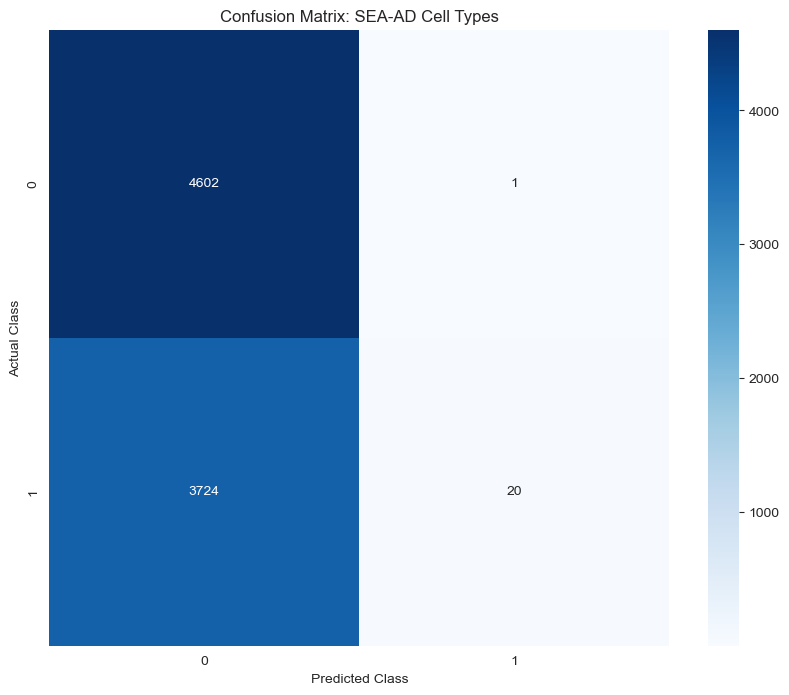

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      4603
           1       0.95      0.01      0.01      3744

    accuracy                           0.55      8347
   macro avg       0.75      0.50      0.36      8347
weighted avg       0.73      0.55      0.40      8347



In [5]:
if data.y is not None:
    y_true = data.y.numpy()
    y_pred = preds.numpy()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Confusion Matrix: SEA-AD Cell Types')
    plt.show()
    
    print(classification_report(y_true, y_pred))

### 5. UMAP Analysis
Projecting GNN latent embeddings to 2D space to visualize cell clustering.

Computing UMAP...


c:\Users\thoma\miniconda3\envs\brain-gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\thoma\miniconda3\envs\brain-gnn\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


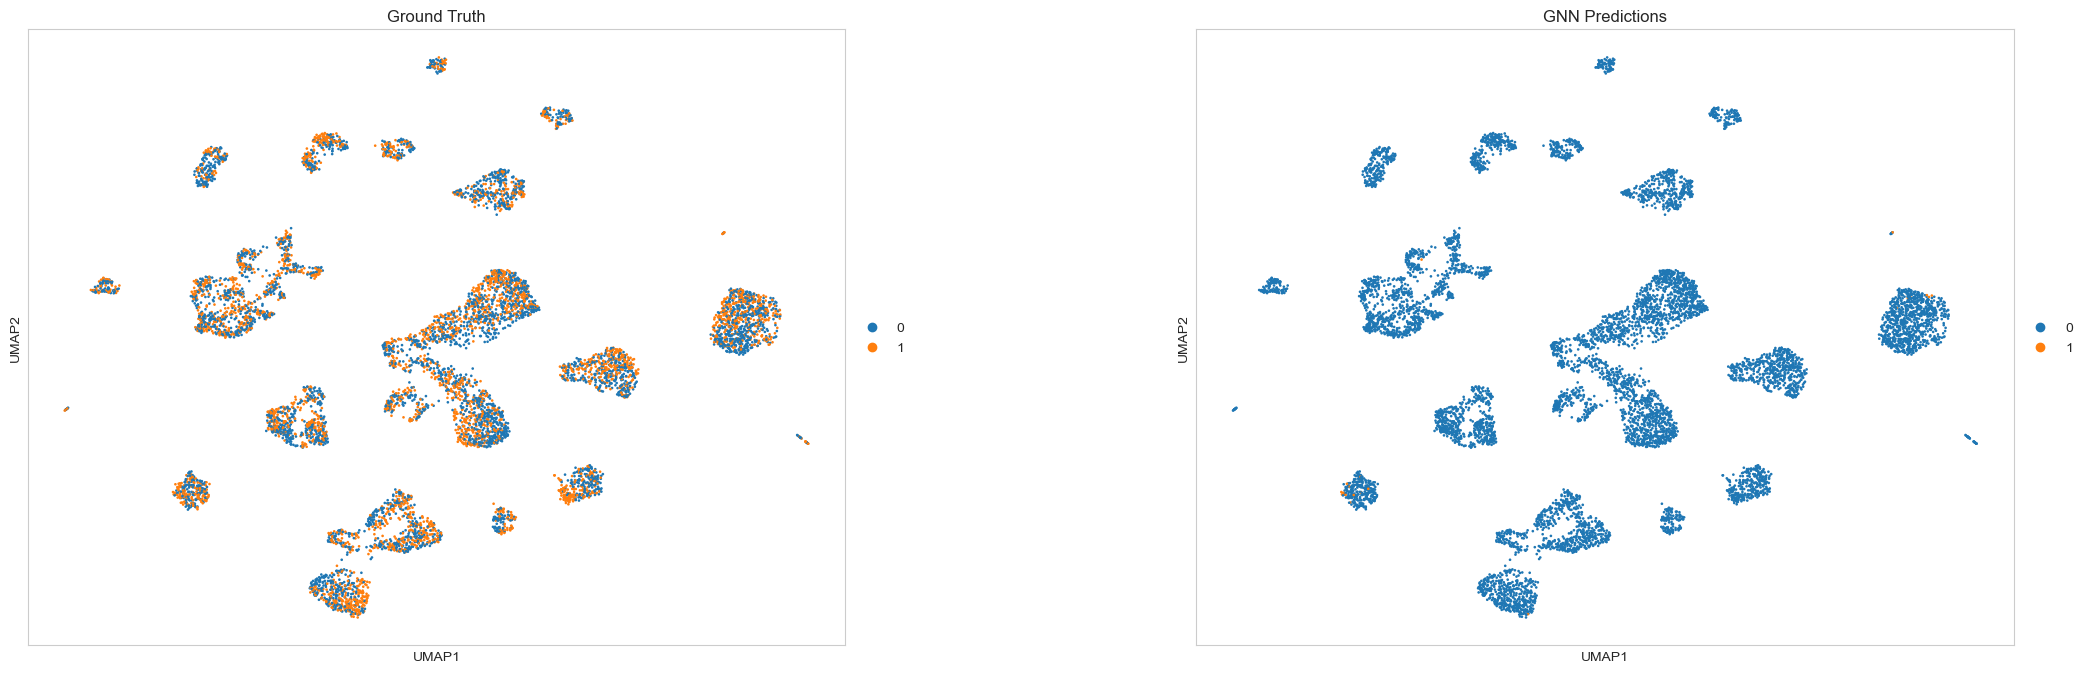

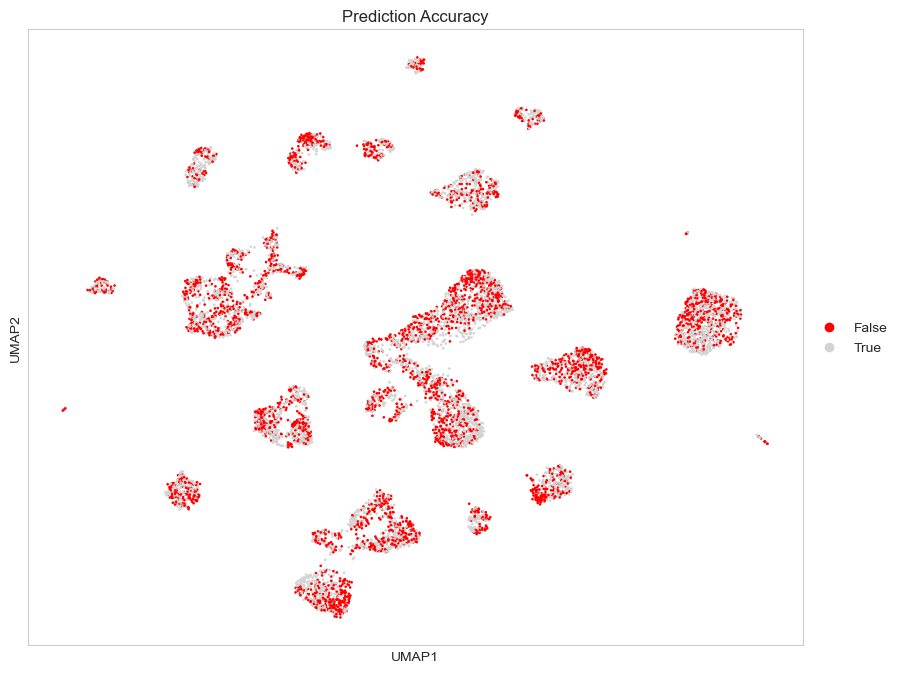

In [6]:
# Extract latent embeddings (output of the first GAT conv layer or before final classifier)
# Since CellGNN returns logits directly, we might need a hook or modify the model to return embeddings.
# Alternatively, we can just UMAP the input features vs predicted classes for now, 
# OR assume the model has a method/submodule to get embeddings. 
# For this notebook, we'll UMAP the *input features* colored by *predicted class* vs *actual class* 
# to see if the raw features + graph structure align with predictions.
# Ideally, we'd want the hidden layer activations.

# Let's use the raw X for UMAP context, colored by predictions.
# Note: data.x is likely PCA components (50 dims) from preprocessing.

adata = sc.AnnData(X=data.x.numpy())
adata.obs['Predicted_Class'] = preds.numpy().astype(str)
if data.y is not None:
    adata.obs['Actual_Class'] = data.y.numpy().astype(str)
    adata.obs['Correct_Prediction'] = (adata.obs['Predicted_Class'] == adata.obs['Actual_Class']).astype(str)

# Compute Neighbors & UMAP
print("Computing UMAP...")
sc.pp.neighbors(adata, use_rep='X', n_neighbors=15)
sc.tl.umap(adata)

# Plot
sc.pl.umap(adata, color=['Actual_Class', 'Predicted_Class'], title=['Ground Truth', 'GNN Predictions'], wspace=0.3)
if data.y is not None:
    sc.pl.umap(adata, color='Correct_Prediction', title='Prediction Accuracy', palette={'True': 'lightgray', 'False': 'red'})